In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fmin_bfgs

import pyquil.quil as pq
import pyquil.api as api
from pyquil.paulis import *
from pyquil.gates import *

from grove.pyqaoa.qaoa import QAOA
from grove.pyvqe.vqe import VQE

import json
import copy


class qRBM:
    """Quantum-Classical Hybrid RBM implementation."""
    def __init__(self, QM, num_visible, num_hidden, n_qaoa_steps=1, beta_temp=2.0, n_quantum_measurements=None, verbose=False):
        """Create an RBM with the specified number of visible and hidden units.

        Args:
            QM (rigetti QVM connection): QVM connection for which to use for
                quantum circuit simulation.
            num_visible (int): Number of visible units in RBM.
            num_hidden (int): Number of hidden units in RBM.
            n_qaoa_steps (int): Defaults to 1.
            beta_temp (float): Defaults to 2.0.
            n_quantum_measurements (int): Number of measuremants to use for
                quantum expectation estimation (default to None which does
                analytical expectation). Defaults to None.
            verbose (bool): Verbosity of qRBM. Defaults to False.

        """
        self.n_visible = num_visible
        self.n_hidden = num_hidden
        self.qvm = QM
        self.verbose = verbose
        self.n_quantum_measurements = n_quantum_measurements
        self.n_qaoa_steps = n_qaoa_steps
        self.beta_temp = beta_temp

        # Only want this for built-in expectation calculations.
        self.vqe_inst = VQE(minimizer=minimize,
                            minimizer_kwargs={'method': 'nelder-mead'})
        self.state_prep_angle = np.arctan(np.exp(-self.beta_temp / 2.0)) * 2.0
        self.WEIGHTS = np.asarray(np.random.uniform(
                                  low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                                  high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                                  size=(num_visible, num_hidden)))

        self.BIAS = np.asarray(np.random.uniform(
                               low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                               high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                               size=(num_hidden)))

    def make_unclamped_QAOA(self):
        """Internal helper function for building QAOA circuit to get RBM expectation
        using Rigetti Quantum simulator.

        Returns:
            nus (list): Optimal parameters for cost hamiltonians in each
                layer of QAOA.
            gammas (list): Optimal parameters for mixer hamiltonians in each
                layer of QAOA
            para_prog (fxn closure): fxn to return QAOA circuit for any
                supplied nus and gammas

        """
        visible_indices = [i for i in range(0, self.n_visible)]
        hidden_indices = [i + self.n_visible for i in range(0, self.n_hidden)]

        full_cost_operator = []
        full_mixer_operator = []

        for i in visible_indices:
            for j in hidden_indices:
                full_cost_operator.append(PauliSum([PauliTerm("Z", i, -1.0 * self.WEIGHTS[i][j - self.n_visible]) * PauliTerm("Z", j, 1.0)]))

        for i in hidden_indices + visible_indices:
            full_mixer_operator.append(PauliSum([PauliTerm("X", i, 1.0)]))

        n_system = len(visible_indices) + len(hidden_indices)

        state_prep = pq.Program()
        for i in visible_indices + hidden_indices:
            tmp = pq.Program()
            tmp.inst(RX(self.state_prep_angle, i + n_system), CNOT(i + n_system, i))
            state_prep += tmp

        full_QAOA = QAOA(self.qvm,
                         n_qubits=n_system,
                         steps=self.n_qaoa_steps,
                         ref_hamiltonian=full_mixer_operator,
                         cost_ham=full_cost_operator,
                         driver_ref=state_prep,
                         store_basis=True,
                         minimizer=fmin_bfgs,
                         minimizer_kwargs={'maxiter': 50},
                         vqe_options={'samples': self.n_quantum_measurements},
                         rand_seed=1234)

        nus, gammas = full_QAOA.get_angles()

        if self.verbose:
            print('Found following values for nus and gammas from QAOA:')
            print(nus)
            print(gammas)
            print('-' * 80)

        program = full_QAOA.get_parameterized_program()

        return nus, gammas, program

    def sigmoid(self, x):
        """Simple helper function to compute sigmoid across data matrix
        where the rows are samples.

        Args:
            x (array): Matrix of data where rows are samples.

        Returns:
            array: That same matrix but with sigmoid applied to entries

        """
        return 1.0 / (1.0 + np.exp(-x))

    def train(self, DATA, learning_rate=0.1, n_epochs=100, quantum_percentage=1.0, classical_percentage=0.0):
        """Train an RBM with mixture of quantum and classical update rules.

        Args:
            DATA (list): Matrix with rows as data samples.
            learning_rate (float): The learning rate used in the update rule by the RBM. Defaults to 0.1.
            n_epochs (int): Number of weight update loops to do over RBM weights. Defaults to 100.
            quantum_percentage (float): Fraction of update rule to be dictated by quantum circuit. Defaults to 1.0.
            classical_percentage (float): Fraction of update rule to be dictated by classical CD-1. Defaults to 0.0.

        NOTE: quantum_percentage + classical_percentage = 1.0 must hold!!!

        """
        assert quantum_percentage + classical_percentage == 1.0

        DATA = np.asarray(DATA)

        for epoch in range(n_epochs):

            print('Beginning epoch', epoch)

            visible_indices = [i for i in range(0, self.n_visible)]
            hidden_indices = [i + self.n_visible for i in range(0, self.n_hidden)]

            new_weights = copy.deepcopy(self.WEIGHTS)
            new_bias = copy.deepcopy(self.BIAS)

            # v------angles------v and program--v
            model_nus, model_gammas, model_para_prog = self.make_unclamped_QAOA()
            model_sampling_prog = model_para_prog(np.hstack((model_nus, model_gammas)))

            print('Found model expectation program...')

            neg_phase_quantum = np.zeros_like(self.WEIGHTS)

            for a in range(self.n_visible):
                for b in range(self.n_hidden):
                    model_expectation = self.vqe_inst.expectation(model_sampling_prog, sZ(visible_indices[a]) * sZ(hidden_indices[b]),
                                                                  self.n_quantum_measurements, self.qvm)

                    neg_phase_quantum[a][b] = model_expectation

            # Follow all standard conventions.
            hidden_probs = self.sigmoid(np.dot(DATA, self.WEIGHTS))
            pos_phase = np.dot(DATA.T, hidden_probs) / len(DATA)

            pos_hidden_states = hidden_probs > np.random.rand(len(DATA), self.n_hidden)

            neg_visible_activations = np.dot(pos_hidden_states, self.WEIGHTS.T)
            neg_visible_probs = self.sigmoid(neg_visible_activations)

            neg_hidden_activations = np.dot(neg_visible_probs, self.WEIGHTS)
            neg_hidden_probs = self.sigmoid(neg_hidden_activations)

            neg_phase_classical = np.dot(neg_visible_probs.T, neg_hidden_probs) / len(DATA)

            if self.verbose:
                print('POSITIVE PHASE')
                print(pos_phase)
                print('NEGATIVE PHASE (QUANTUM)')
                print(neg_phase_quantum)
                print('NEGATIVE PHASE (CLASSICAL)')
                print(neg_phase_classical)
                print('WEIGHTS')
                print(self.WEIGHTS)
                print('-' * 80)

            # Can update weights with weighted avg of quantum and classical.
            new_weights += learning_rate * (pos_phase -
                                            (classical_percentage * neg_phase_classical +
                                             quantum_percentage * neg_phase_quantum))

            self.WEIGHTS = copy.deepcopy(new_weights)
            self.BIAS = copy.deepcopy(new_bias)

            with open("RBM_info.txt", "w") as myfile:
                myfile.write(json.dumps(list(self.WEIGHTS.tolist())) + '\n')
                myfile.write(json.dumps(list(self.BIAS.tolist())) + '\n')

            with open("RBM_history.txt", "a") as myfile:
                myfile.write(json.dumps(list(self.WEIGHTS.tolist())) + '\n')
                myfile.write(json.dumps(list(self.BIAS.tolist())) + '\n')
                myfile.write(str('-' * 80) + '\n')

            print('')

        print('Training Done!')

    def transform(self, x):
        """Transforms vectors from visible to hidden.

        Args:
            x (list): Matrix containing rows that are data samples.

        Returns:
            list: The hidden layers invoked from the samples in data matrix.

        """
        return self.sigmoid(np.dot(x, self.WEIGHTS))


In [5]:
from pyquil.quil import Program
from pyquil.paulis import PauliSum, PauliTerm, exponentiate, exponential_map, trotterize
from pyquil.gates import MEASURE, H, Z, RX, RZ, CZ
import numpy as np

In [6]:
from numpy import pi
theta = pi/3
xy = PauliTerm('X', 0) * PauliTerm('Y', 1, 1j/3)

In [7]:
print(xy)

0.3333333333333333j*X0*Y1


In [29]:
print(PauliSum([xy]))

0.3333333333333333j*X0*Y1


In [9]:
# Setup a Rigetti qvm connection
qvm = api.QVMConnection()

In [11]:
# #Creat an instance of a qRBM
# r = qRBM(qvm, num_visible=4, num_hidden=1, n_quantum_measurements=None, verbose=False)
# # simple artificially high dimensional data
# simple_data = [[1,1,-1,-1], [1,1,-1,-1], [-1,-1,1,1], [-1,-1,1,1]]

#Creat an instance of a qRBM
r = qRBM(qvm, num_visible=6, num_hidden=3, n_quantum_measurements=None, verbose=False)
# simple artificially high dimensional data
simple_data = [[1,1,-1,-1], [1,1,-1,-1], [-1,-1,1,1], [-1,-1,1,1]]

#train for 100 epochs using only quantum calculated negative phase in update rule.
r.train(simple_data, n_epochs=100, quantum_percentage=1.0, classical_percentage=0.0)

Beginning epoch 0
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 1
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 2
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 3
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Functi


Beginning epoch 25
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 26
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 27
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 28
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         F


Beginning epoch 50
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 51
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 52
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 53
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         F


Beginning epoch 75
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 76
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 77
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Found model expectation program...

Beginning epoch 78
                     models will be ineffective
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         F


Training Done!


In [14]:
# transorm down to 1 dimension to see how we did.
print(r.transform(simple_data))

[[  9.99998835e-01]
 [  9.99998835e-01]
 [  1.16514236e-06]
 [  1.16514236e-06]]


In [28]:
from rbm import RBM

In [147]:
r_classic = RBM(8, 7, debug_print=False)

simple_data = [[1,1,0,0,0,0,0,0],
               [0,0,1,1,0,0,0,0],
               [0,0,0,0,1,1,0,0],
               [0,0,0,0,0,0,1,1]]
r_classic.train(np.array(simple_data), max_epochs=10000)
r_classic.run_visible(np.array(simple_data))

array([[ 1.,  1.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 1.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  1.,  1.]])

In [122]:
r_classic.run_visible(np.array(simple_data))

array([[ 0.,  1.,  0.,  1.],
       [ 1.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  1.],
       [ 0.,  1.,  1.,  0.]])

In [15]:
with open('RBM_history_1.txt', 'r') as f:
    history = f.readlines()

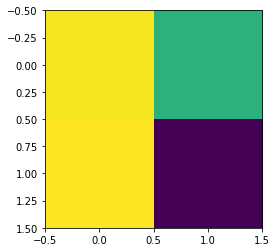

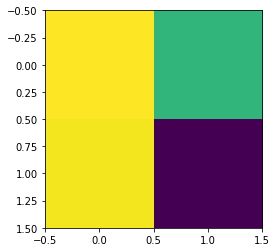

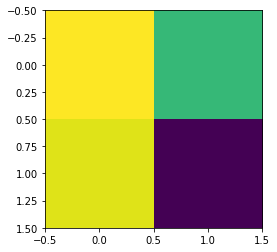

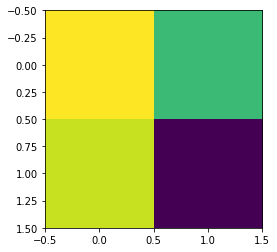

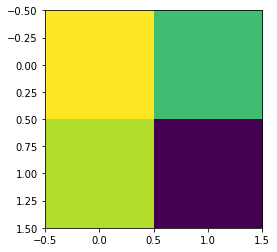

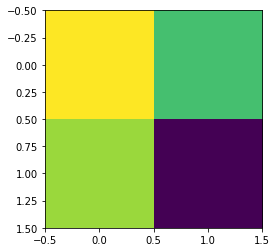

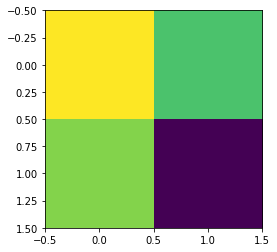

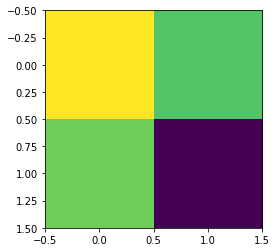

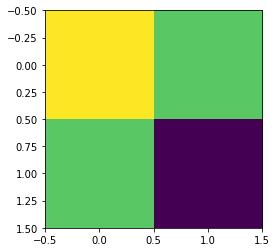

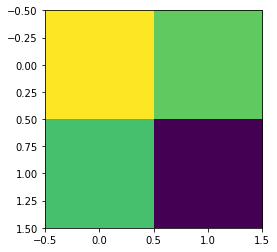

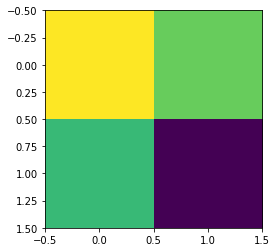

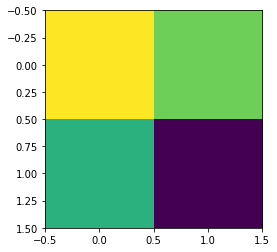

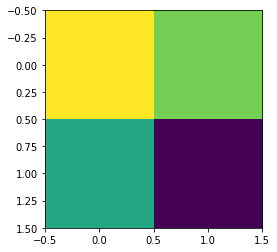

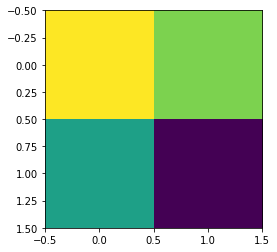

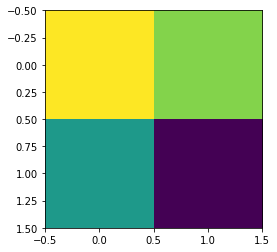

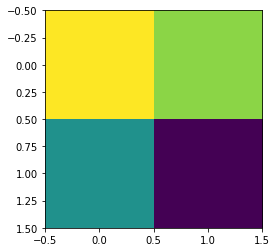

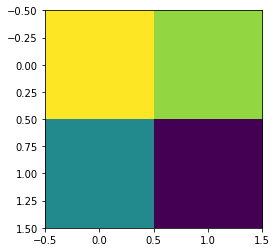

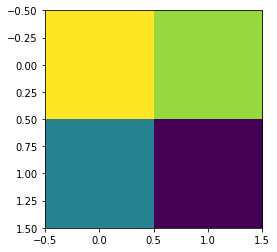

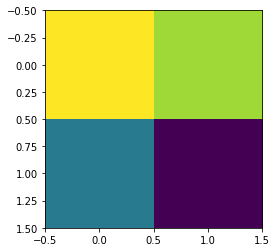

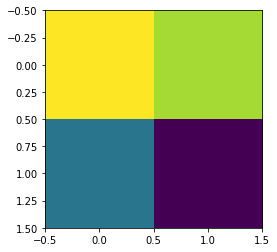

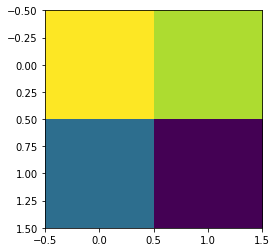

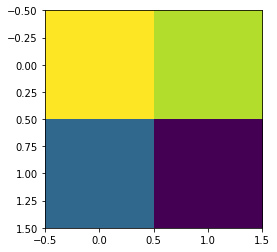

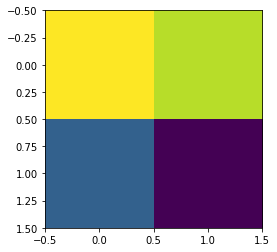

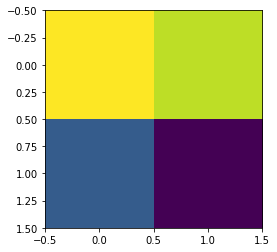

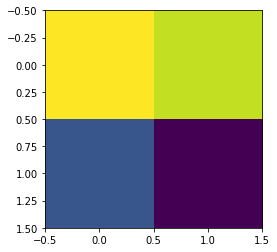

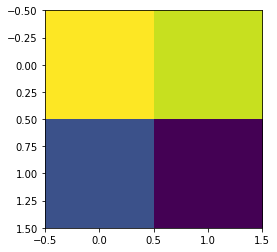

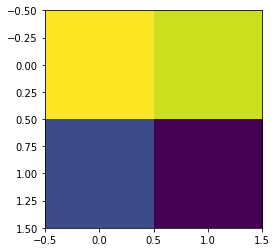

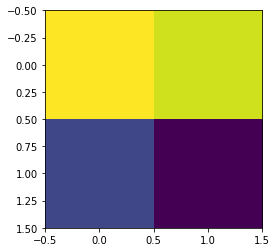

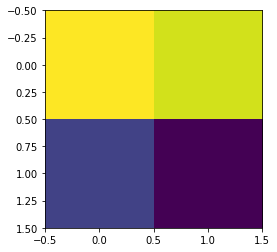

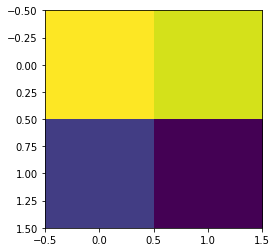

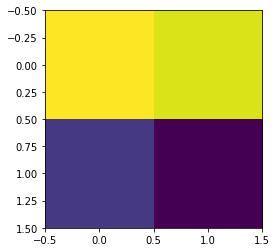

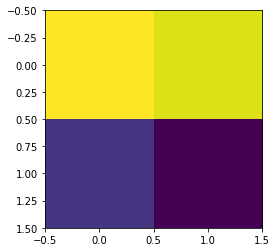

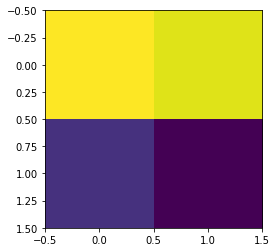

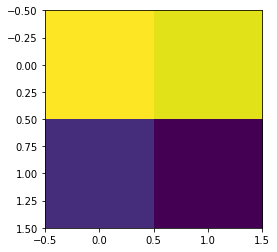

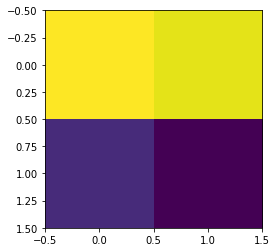

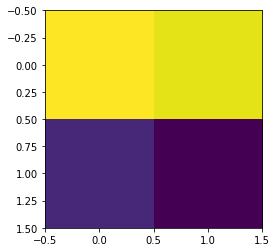

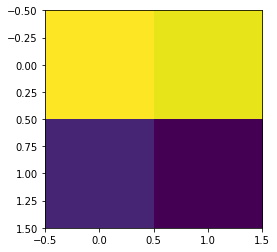

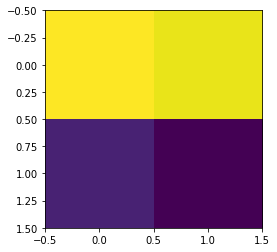

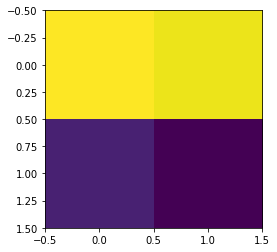

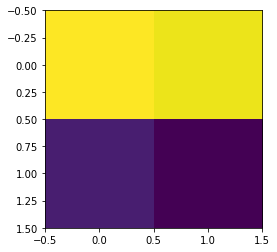

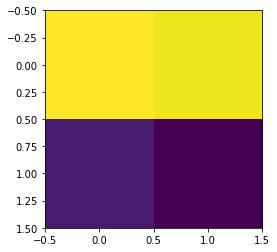

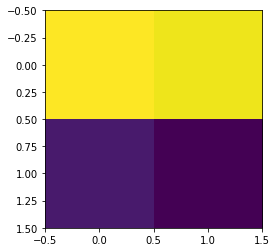

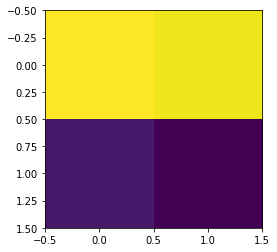

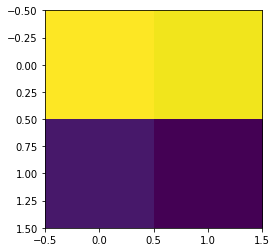

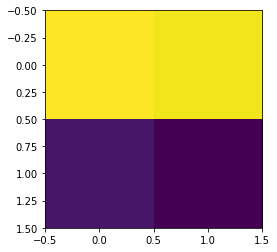

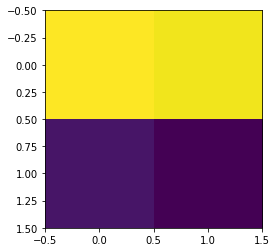

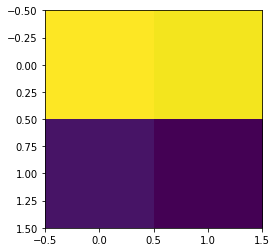

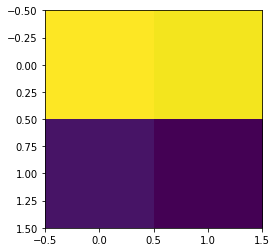

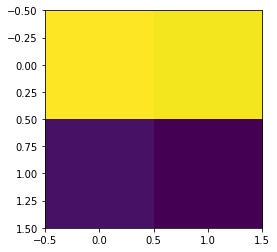

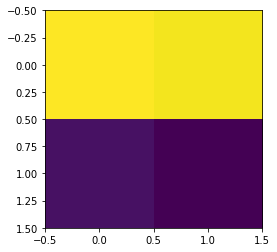

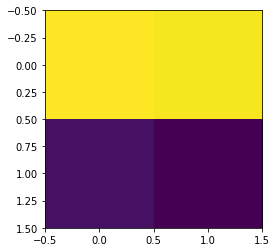

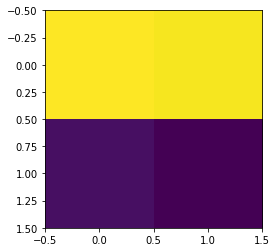

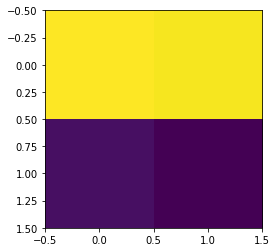

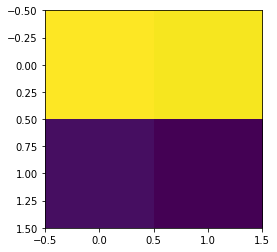

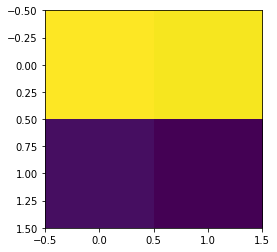

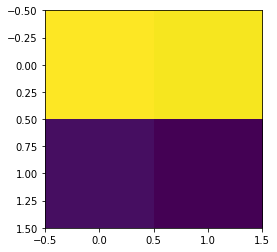

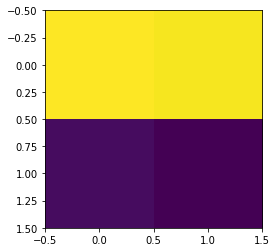

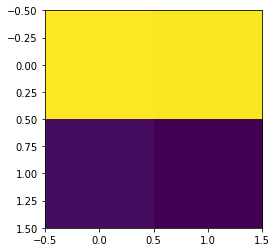

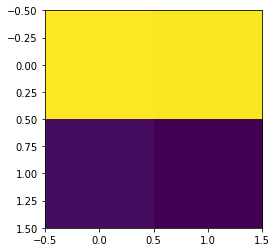

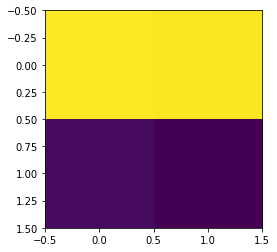

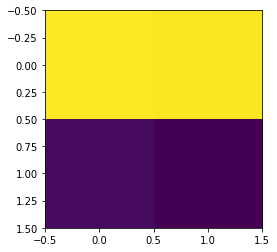

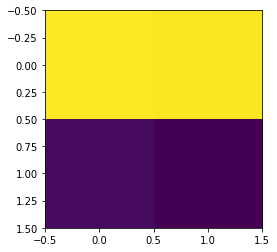

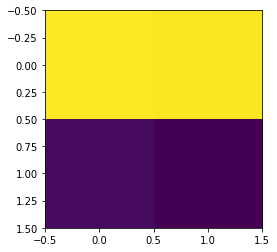

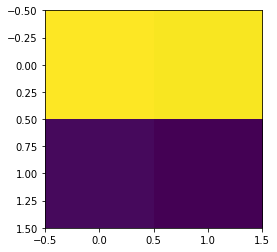

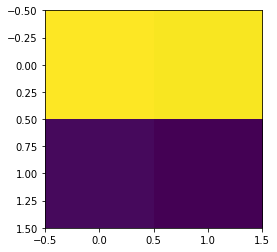

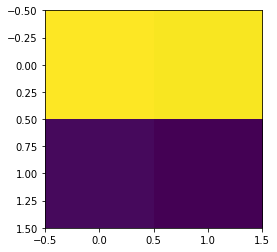

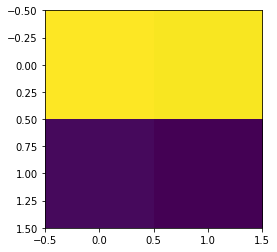

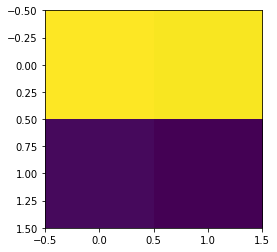

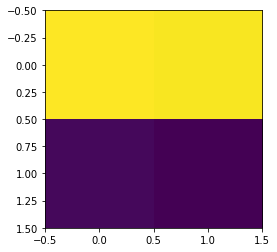

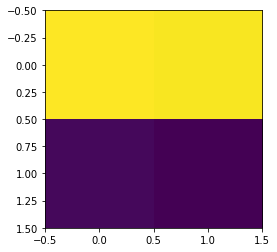

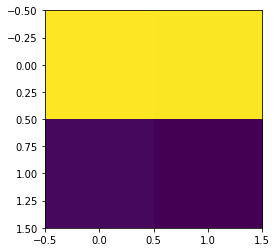

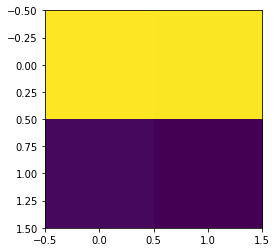

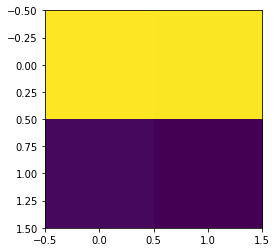

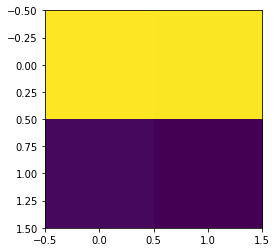

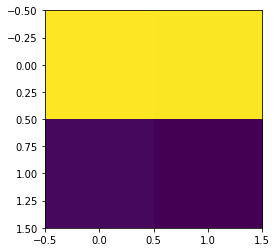

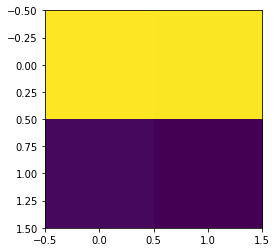

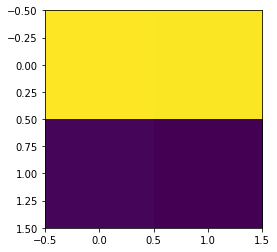

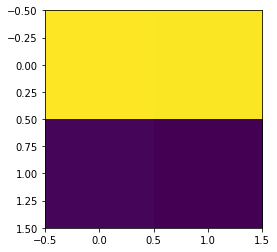

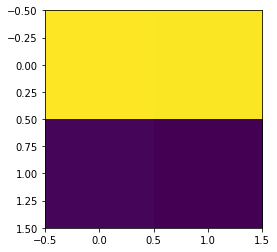

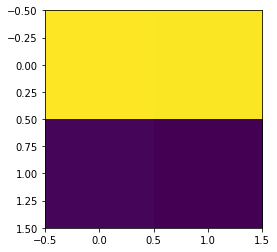

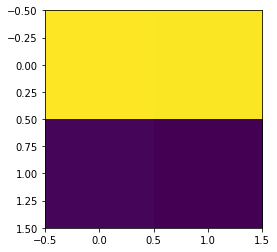

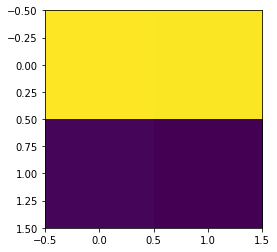

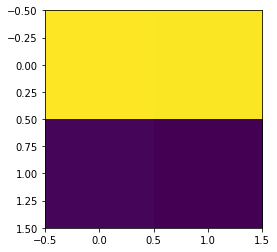

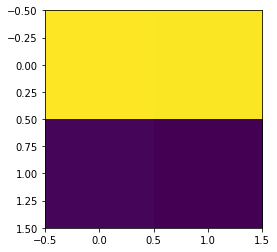

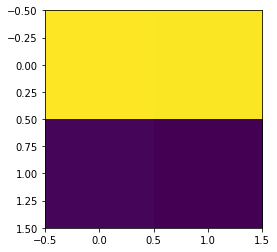

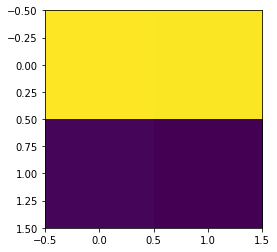

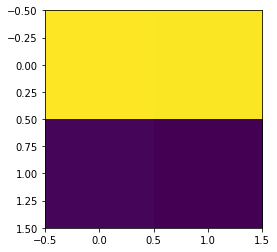

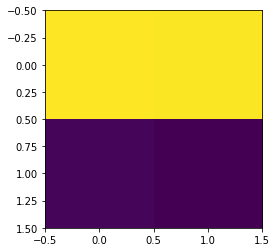

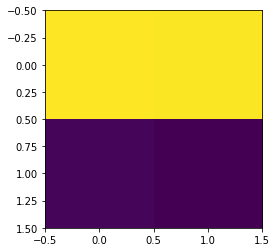

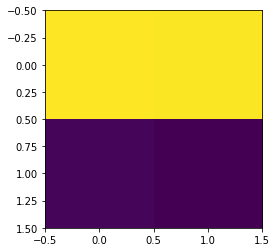

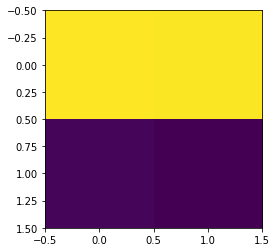

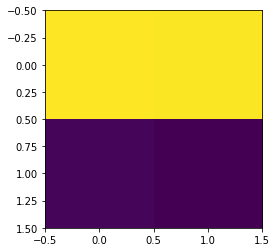

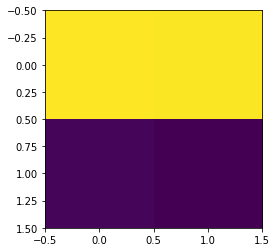

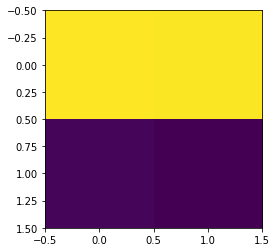

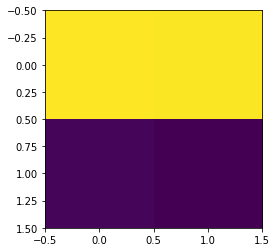

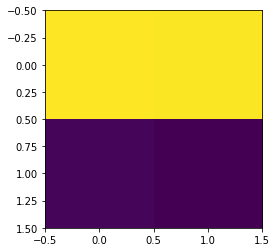

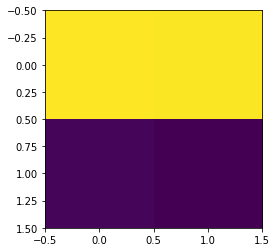

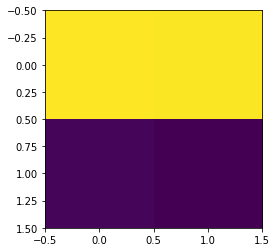

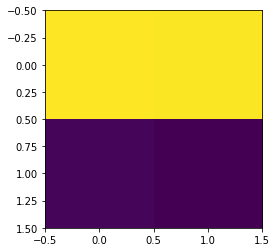

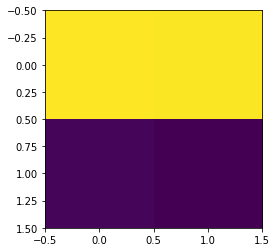

In [26]:
for i in range(len(history[::3])):
    plt.imshow(np.array(json.loads(history[::3][i])).reshape((2,2)))
    plt.show()

In [27]:
history[::3][-1]

'[[3.427703459397946], [3.397086162860169], [-3.374708880763461], [-3.4631676143397936]]\n'